# Chapter 5 NLP

In [35]:
%matplotlib inline

In [36]:
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import glob

import scattertext

import tensorflow as tf
from tensorflow import keras

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from spacy.lang.en import English  # run `python -m spacy.en.download` to download 

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

sns.set()

### Preprocessing

In [3]:
corpus = [
    "movie was awesome, a must see",
    "wasn't overly impressed with the movie at all",
    "the movie was not good at all, it was a waste of time",
]

In [70]:
tokenized_corpus = [document.split() for document in corpus]
tokenized_corpus

[['movie', 'was', 'awesome,', 'a', 'must', 'see'],
 ["wasn't", 'overly', 'impressed', 'with', 'the', 'movie', 'at', 'all'],
 ['the',
  'movie',
  'was',
  'not',
  'good',
  'at',
  'all,',
  'it',
  'was',
  'a',
  'waste',
  'of',
  'time']]

#### regex

In [105]:
token_pattern = r"\b\w\w+\b"

In [107]:
re.findall(token_pattern, corpus[0])

['movie', 'was', 'awesome', 'must', 'see']

In [109]:
re.findall(token_pattern, "do u? i don't :(")

['do', 'don']

#### sequence of tokens

In [71]:
vocab = {
    token
    for sentence in corpus
    for token in sentence.split()
}
token_to_index = dict(zip(vocab, range(len(vocab))))
token_to_index

{'with': 0,
 'the': 1,
 'good': 2,
 'at': 3,
 'not': 4,
 'waste': 5,
 'of': 6,
 'impressed': 7,
 'a': 8,
 "wasn't": 9,
 'it': 10,
 'overly': 11,
 'awesome,': 12,
 'time': 13,
 'was': 14,
 'all': 15,
 'movie': 16,
 'see': 17,
 'must': 18,
 'all,': 19}

In [72]:
[
    [token_to_index[token] for token in sentence.split()]
    for sentence in corpus
]

[[16, 14, 12, 8, 18, 17],
 [9, 11, 7, 0, 1, 16, 3, 15],
 [1, 16, 14, 4, 2, 3, 19, 10, 14, 8, 5, 6, 13]]

In [77]:
# BOW
pd.DataFrame([
    Counter(sentence.split())
    for sentence in corpus
]).fillna(0)

,a,all,"all,",at,"awesome,",good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn't,waste,with
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0


### Normalization

#### Stemming

In [158]:
words = ['forbid', 'forbidden', 'forbade', 'forbids']
porter = PorterStemmer()

In [159]:
[
    porter.stem(word)
    for word in words
]

['forbid', 'forbidden', 'forbad', 'forbid']

In [160]:
porter.stem('marketing')

'market'

In [162]:
snowball = SnowballStemmer('english')

In [163]:
[
    snowball.stem(word)
    for word in ['forbid', 'forbidden', 'forbade', 'forbids']
]

['forbid', 'forbidden', 'forbad', 'forbid']

### Lemmatization

In [167]:
wordnetlemmatizer = WordNetLemmatizer()
wordnetlemmatizer.lemmatize('marketing')

'marketing'

In [169]:
wordnetlemmatizer.lemmatize('forbade')

'forbade'

##### POS tagger

In [232]:
# nltk.download('averaged_perceptron_tagger')

In [173]:
sentence = 'i forbade him from getting involved in the marketing scheme'
pos_tags = nltk.pos_tag(sentence.split())
pos_tags

[('i', 'NN'),
 ('forbade', 'VBD'),
 ('him', 'PRP'),
 ('from', 'IN'),
 ('getting', 'VBG'),
 ('involved', 'VBN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('marketing', 'NN'),
 ('scheme', 'NN')]

In [174]:
wordnetlemmatizer.lemmatize('forbade', 'v')

'forbid'

### Bringing it all together

#### [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [182]:
cv = CountVectorizer()
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [183]:
# binary, jusy saying
cv = CountVectorizer(binary=True)
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,0,1,0


In [187]:
cv = CountVectorizer(stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,impressed,movie,overly,time,wasn,waste
0,1,0,0,1,0,0,0,0
1,0,0,1,1,1,0,1,0
2,0,1,0,1,0,1,0,1


In [184]:
# exact same tokenizer as before
cv = CountVectorizer(tokenizer=lambda sentence: sentence.split())
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,a,all,"all,",at,"awesome,",good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn't,waste,with
0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [185]:
cv = CountVectorizer(vocabulary={'awesome', 'good', 'waste'})
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,awesome,good,waste
0,1,0,0
1,0,0,0
2,0,1,1


#### N-grams

In [197]:
unigrams = re.findall(token_pattern, corpus[0])
unigrams

['movie', 'was', 'awesome', 'must', 'see']

In [201]:
[
    ' '.join(unigrams[i:i+2])
    for i in range(len(unigrams) - 1)
]

['movie was', 'was awesome', 'awesome must', 'must see']

In [204]:
cv = CountVectorizer(ngram_range=(2, 2), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,good waste,impressed movie,movie awesome,movie good,overly impressed,wasn overly,waste time
0,0,0,1,0,0,0,0
1,0,1,0,0,1,1,0
2,1,0,0,1,0,0,1


### [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

#### Inverse Document Frequency (IDF)

In [211]:
def idf(docs, df, normalize=True):
    normalizer = 1 if normalize else 0
    return np.log((docs + normalizer) / (df + normalizer)) + 1

In [212]:
idf(3, 1)

1.6931471805599454

In [213]:
idf(3, 2)

1.2876820724517808

In [214]:
idf(3, 3)

1.0

In [216]:
idf(10, 1)

2.7047480922384253

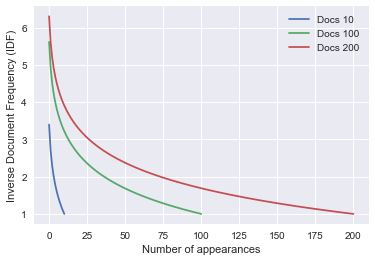

In [222]:
for docs in [10, 100, 200]:
    docs_range = range(0, docs + 1)
    plt.plot(docs_range, [idf(docs, d) for d in docs_range], label='Docs {}'.format(docs))
    
plt.xlabel('Number of appearances')
plt.ylabel('Inverse Document Frequency (IDF)')
plt.legend();

In [241]:
corpus[0]

'movie was awesome, a must see'

In [234]:
# l2 normalization
idfs = np.array([1 * idf(3, 3),  # movie
                 1 * idf(3, 2),  # was
                 1 * idf(3, 1),  # awesome
                 1 * idf(3, 1),  # must
                 1 * idf(3, 1)  # see
                ])
idfs

array([1.        , 1.28768207, 1.69314718, 1.69314718, 1.69314718])

In [235]:
idfs / np.linalg.norm(idfs) 

array([0.29803159, 0.38376993, 0.50461134, 0.50461134, 0.50461134])

In [31]:
tfidf = CountVectorizer()
a = tfidf.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=tfidf.get_feature_names())

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [255]:
tfidf = TfidfVectorizer()
a = tfidf.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=tfidf.get_feature_names())

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0.000000,0.000000,0.504611,0.000000,0.000000,0.000000,0.298032,0.504611,0.000000,0.000000,0.000000,0.504611,0.000000,0.000000,0.383770,0.000000,0.000000,0.000000
1,0.308332,0.308332,0.000000,0.000000,0.405419,0.000000,0.239447,0.000000,0.000000,0.000000,0.405419,0.000000,0.308332,0.000000,0.000000,0.405419,0.000000,0.405419
2,0.235856,0.235856,0.000000,0.310122,0.000000,0.310122,0.183163,0.000000,0.310122,0.310122,0.000000,0.000000,0.235856,0.310122,0.471712,0.000000,0.310122,0.000000


#### [spaCy](https://spacy.io/)

In [278]:
nlp = English()

In [283]:
sentence

'i forbade him from getting involved in the marketing scheme'

In [282]:
[w.lemma_ for w in nlp(sentence)]

['i',
 'forbid',
 'him',
 'from',
 'get',
 'involve',
 'in',
 'the',
 'market',
 'scheme']

In [305]:
def tokenizer(doc):
    parser = English()
    tokens = parser(doc)
    
    # remove
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    stop = stop_words.union(punctuation)

    tokens = [token.lemma_.lower().strip()
              for token in tokens]
    return [token for token in tokens if token not in stop]

cv = CountVectorizer(tokenizer=tokenizer)
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,impress,movie,must,overly,see,time,waste
0,1,0,0,1,1,0,1,0,0
1,0,0,1,1,0,1,0,0,0
2,0,1,0,1,0,0,0,1,1


## Modeling

### Traditional machine learning

#### [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [315]:
# doc1 (pos): movie was awesome, a must see
# doc2 (neg): wasn't overly impressed with the movie at all
# doc3 (neg): the movie was not good at all, it was a waste of time
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(corpus).toarray()
y = [1, 0, 0]

In [316]:
lr = LogisticRegression()
lr.fit(x, y)
lr.predict(x)

array([1, 0, 0])

In [322]:
type(x)

numpy.ndarray

In [321]:
x.shape

(3, 18)

In [317]:
lr.coef_[0].shape

(18,)

In [326]:
def plot_lr_coefficients(tfidf, corpus, y):
    a = tfidf.fit_transform(corpus)
    x = tfidf.transform(corpus).toarray()
    lr = LogisticRegression()
    lr.fit(x, y)
    df = pd.DataFrame({'Token': tfidf.get_feature_names(), 'Coefficient': lr.coef_[0]})
    df['Positive'] = df.Coefficient > 0
    colors = df.Positive.map({True: 'b', False: 'r'})
    df.set_index('Token').plot(kind='barh', color=[colors], legend=False, figsize=(8, 6))
    plt.xlabel('Coefficient')

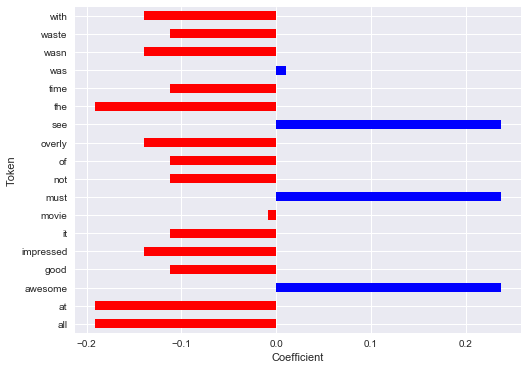

In [328]:
plot_lr_coefficients(TfidfVectorizer(), corpus, y)

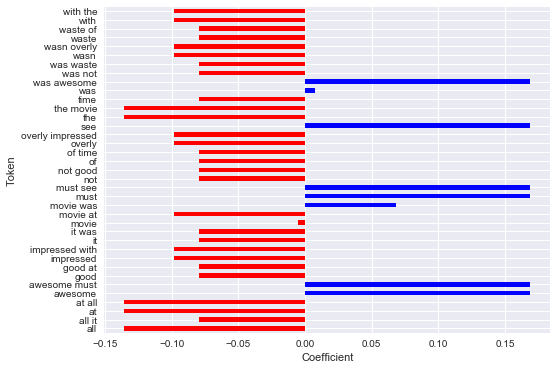

In [331]:
plot_lr_coefficients(TfidfVectorizer(ngram_range=(1, 2)), corpus, y)

### IMDB review sentiment data

In [442]:
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xzf aclImdb_v1.tar.gz
# !rm aclImdb_v1.tar.gz

--2018-05-15 18:45:20--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu... 171.64.68.10
Connecting to ai.stanford.edu|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.5MB/s    in 5.3s    

2018-05-15 18:45:26 (15.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
def get_reviews(data_partition, class_label):
    path = 'aclImdb/{}/{}/*.txt'.format(data_partition, class_label)
    return [
        open(f).read()
        for f in glob.glob(path)
    ]

def get_dataset(data_partition):
    pos = get_reviews(data_partition, 'pos')
    neg = get_reviews(data_partition, 'neg')
    print('Found {} positive and {} negative examples'.format(len(pos), len(neg)))
    data = pos + neg
    labels = np.array([1 for _ in range(len(pos))] + [0 for _ in range(len(neg))])
    return data, labels

In [4]:
%%time
data_train, y_train = get_dataset('train')
data_test, y_test = get_dataset('test')

Found 12500 positive and 12500 negative examples
Found 12500 positive and 12500 negative examples
CPU times: user 2.98 s, sys: 3.53 s, total: 6.52 s
Wall time: 15 s


In [6]:
type(data_train)

list

In [7]:
len(data_train)

25000

In [8]:
len(data_test)

25000

In [9]:
data_train[0]

'For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.'

In [341]:
data_train[12505]

'I had been looking forward to seeing this film for a long time, after seeing "Return to Paradise," which I found to be gritty. I was so disappointed. The most realistic thing about it was the unpredictable ending which I think was partly stolen from "Return to Paradise." <br /><br />Maybe I was expecting too much. <br /><br />On the positive side Danes, Beckinsale and Pullman were fantastic in their roles. Although I didnt like Danes\'s character and first and found her very annoying. <br /><br />I couldnt see anything realistic about the film. It could of been done so much better, for example there could of been more emphasis on the prison conditions and the sheer horror. It was too cheery a movie to be realistic. There could also of been more action and tension<br /><br />The best thing about this film is the "tragic" ending. I couldnt of predicted that. But by that time I really didnt care what happened to them.<br /><br />3/10'

In [65]:
%%time
vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_df=0.8, min_df=2)
x_train = vec.fit_transform(data_train)

CPU times: user 3.97 s, sys: 158 ms, total: 4.12 s
Wall time: 3.91 s


In [66]:
len(vec.vocabulary_)

44490

In [358]:
# low frequency tokens
[k for k, v in vec.vocabulary_.items() if v <= 10]

['000',
 '00',
 '007',
 '01',
 '00s',
 '0080',
 '0083',
 '00pm',
 '00am',
 '001',
 '00001']

In [366]:
%%time
cvs = cross_val_score(LogisticRegression(), x_train, y_train, cv=5)
print(cvs)

[0.8924 0.8876 0.8902 0.8764 0.8892]
CPU times: user 7.22 s, sys: 113 ms, total: 7.34 s
Wall time: 1.89 s


In [370]:
np.std(cvs)

0.005600571399419893

In [368]:
np.mean(cvs)

0.88716

In [59]:
def traditional_ml(vec_class, model_object,
                   stop_words, ngram_range, max_df, min_df, cv, n=10):
    vec = vec_class(stop_words=stop_words,
                    ngram_range=ngram_range,
                    max_df=max_df, min_df=min_df)
    x_train = vec.fit_transform(data_train)
    print('Vocabulary size: {}'.format(len(vec.vocabulary_)))
    scores = cross_val_score(model_object, x_train, y_train, cv=cv)
    scores_mean = scores.mean()
    scores_std = scores.std()
    print('Cross-validation scores mean: {:.2f}%, std: {:.2f}%'.format(scores_mean * 100,
                                                                       scores_std * 100))
    
    # Visualize the importance of tokens
    if model_object.__class__ == LogisticRegression:
        lr = model_object
        lr.fit(x_train, y_train)
        coefs = pd.DataFrame({'coef': lr.coef_[0]},
                             index=vec.get_feature_names()).sort_values(by='coef', ascending=False)
        coefs_topn = pd.concat([coefs[:n], coefs[-n:]])
        positive = coefs_topn.coef >= 0
        colors = positive.map({True: 'b', False: 'r'})
        colors
        coefs_topn.plot(kind='barh', color=[colors],
                        legend=False, figsize=(8, 6))
        plt.xlabel('Coefficient')
    elif model_object.__class__ == RandomForestClassifier:
        rf = model_object
        rf.fit(x_train, y_train)
        importances = zip(vec.get_feature_names(),
                          rf.feature_importances_)
        importances_series = pd.Series(dict(importances))
        
        importances_sorted = importances_series.sort_values(ascending=False)
        importance_sorted_topn = importances_sorted[:n][::-1]
        importance_sorted_topn.plot(kind='barh', color='k')
        plt.xlabel('Gini importance (higher means more important)')
        plt.ylabel('Token')
        plt.show()

Vocabulary size: 44490
Cross-validation scores mean: 88.72%, std: 0.56%
CPU times: user 16.7 s, sys: 266 ms, total: 17 s
Wall time: 9.75 s


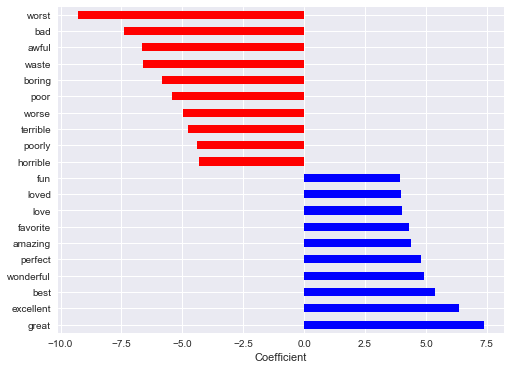

In [14]:
%%time
traditional_ml(vec_class=CountVectorizer,
               model_object=LogisticRegression(),
               stop_words='english',
               ngram_range=(1, 1),
               max_df=0.8,
               min_df=2,
               cv=5)

Vocabulary size: 80865
Cross-validation scores mean: 89.26%, std: 0.46%
CPU times: user 3min 11s, sys: 3.71 s, total: 3min 15s
Wall time: 1min 13s


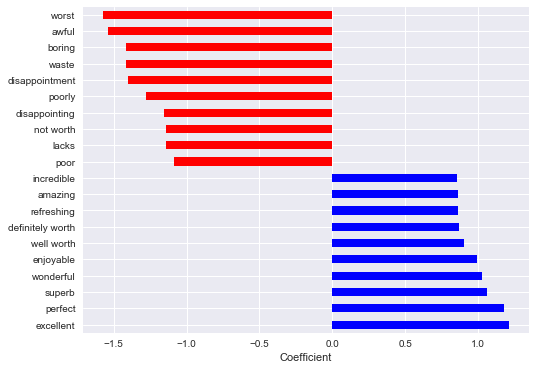

In [20]:
%%time
traditional_ml(vec_class=CountVectorizer,
               model_object=LogisticRegression(),
               stop_words=None,
               ngram_range=(1, 2),
               max_df=0.8,
               min_df=10,
               cv=5)

Vocabulary size: 44490
Cross-validation scores mean: 76.68%, std: 0.31%


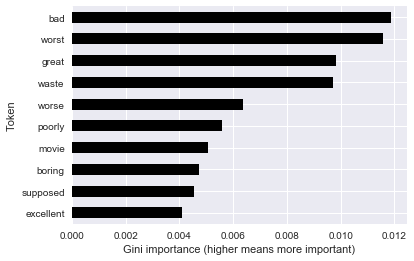

CPU times: user 33.5 s, sys: 570 ms, total: 34 s
Wall time: 30.7 s


In [60]:
%%time
traditional_ml(vec_class=TfidfVectorizer,
               model_object=RandomForestClassifier(),
               stop_words='english',
               ngram_range=(1, 1),
               max_df=0.8,
               min_df=2,
               cv=5)

### Feed forward networks

In [191]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_df=0.8, min_df=2)
x_train = vec.fit_transform(data_train)

In [192]:
x_train

<25000x44490 sparse matrix of type '<class 'numpy.float64'>'
	with 2211745 stored elements in Compressed Sparse Row format>

In [193]:
model = Sequential()
model.add(Dense(16,
                input_dim=x_train.shape[1],
                activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 16)                711856    
_________________________________________________________________
dropout_139 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_140 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 17        
Total params: 712,145
Trainable params: 712,145
Non-trainable params: 0
_________________________________________________________________


In [194]:
%%time
history = model.fit(x_train.toarray(), y_train,
          epochs=10, batch_size=128,
          validation_split=0.25);

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 20s 1ms/step - loss: 0.6173 - acc: 0.6666 - val_loss: 0.9181 - val_acc: 0.0128
Epoch 2/10
18750/18750 [==============================] - 14s 761us/step - loss: 0.4175 - acc: 0.8115 - val_loss: 0.5749 - val_acc: 0.7554
Epoch 3/10
18750/18750 [==============================] - 12s 652us/step - loss: 0.2388 - acc: 0.9229 - val_loss: 0.5260 - val_acc: 0.7827
Epoch 4/10
18750/18750 [==============================] - 11s 576us/step - loss: 0.1562 - acc: 0.9545 - val_loss: 0.5168 - val_acc: 0.8054
Epoch 5/10
18750/18750 [==============================] - 11s 562us/step - loss: 0.1125 - acc: 0.9699 - val_loss: 0.5870 - val_acc: 0.8016
Epoch 6/10
18750/18750 [==============================] - 12s 615us/step - loss: 0.0841 - acc: 0.9785 - val_loss: 0.6131 - val_acc: 0.8099
Epoch 7/10
18750/18750 [==============================] - 11s 594us/step - loss: 0.0628 - acc: 0.9837 - val_loss: 0.814

In [195]:
history.history

{'val_loss': [0.9181316896057129,
  0.5749172664070129,
  0.5259741052627563,
  0.5167704172897339,
  0.5869859335517883,
  0.6131401355171203,
  0.8145655102157593,
  0.906516630859375,
  1.0010718478393554,
  1.092448123550415],
 'val_acc': [0.012800000002384185,
  0.7553600003051758,
  0.7827200004386902,
  0.8054399995613098,
  0.8016000004386902,
  0.8099200001907348,
  0.7777599996757507,
  0.7740799996757507,
  0.7705600003051758,
  0.7663999999237061],
 'loss': [0.6172650164095561,
  0.4175434952640533,
  0.238767218875885,
  0.15617940152804058,
  0.11249321137666703,
  0.08406311997413635,
  0.06284054720600446,
  0.05225476991732915,
  0.04392873775253693,
  0.03665901259303093],
 'acc': [0.6666133332761128,
  0.8114666666285197,
  0.9228800000508627,
  0.9544533332379659,
  0.9698666665712993,
  0.9784533332888286,
  0.983733333384196,
  0.9854399999046326,
  0.98864,
  0.9900266667175293]}

In [196]:
def plot_history(history,
                 show_accuracy=True,
                 show_loss=True):
    better_name = {
        'val_loss': 'Validation loss',
        'val_acc': 'Validation accuracy',
        'loss': 'Training loss',
        'acc': 'Training accuracy'
    }
    history_df = pd.DataFrame(history.history)
    history_df.columns = [better_name[c] for c in history_df.columns]
    history_df.index += 1
    if show_accuracy:
        history_df[['Training accuracy',
                    'Validation accuracy']].plot()
        plt.ylim([0, 1.1])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (higher is better)')
        plt.show()
    if show_loss:
        loss = history_df[['Training loss',
                           'Validation loss']]
        loss.plot()
        plt.xlabel('Epoch')
        plt.ylabel('Loss (lower is better)')
        plt.ylim([0, max(loss.max())])
        plt.show()

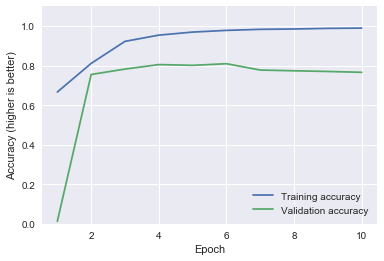

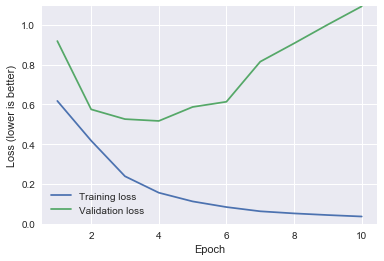

In [198]:
plot_history(history)

In [134]:
terms = ['excellent', 'great', 'movie', 'terrible', 'worst']
# get the index associated with each term in the vectorizer
term_indices = list(map(vec.get_feature_names().index, terms))
term_indices

[13714, 17112, 26181, 39522, 43915]

In [146]:
model.get_weights()[0][term_indices].shape

(5, 16)

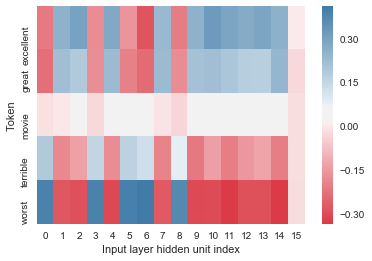

In [147]:
weights = pd.DataFrame(model.get_weights()[0][term_indices])
weights.index = terms
# blue to red diverging palette
cmap = sns.diverging_palette(10, 240, sep=20, as_cmap=True)
sns.heatmap(weights, cmap=cmap)
plt.xlabel('Input layer hidden unit index')
plt.ylabel('Token')
plt.show()

#### [scattertext](https://github.com/JasonKessler/scattertext)
bonus material

In [269]:
%%time
labels = ['Positive' if y == 1 else 'Negative' for y in y_train]
scattertext_df = pd.DataFrame({'text': data_train, 'label': labels})
corpus = scattertext.CorpusFromPandas(scattertext_df,
                                      category_col='label', text_col='text',
                                      nlp=scattertext.whitespace_nlp_with_sentences).build()

CPU times: user 1min 24s, sys: 1.25 s, total: 1min 26s
Wall time: 1min 26s


In [270]:
type(corpus)

scattertext.Corpus.Corpus

In [271]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['doesn', 'didn', 'isn', 've', 'wasn', 'film', 'don', 'plot', 'acting', 'scenes']


In [274]:
%%time
html = scattertext.produce_scattertext_explorer(corpus,
                                                category='Positive',
                                                category_name='Positive',
                                                max_terms=5000,
                                                not_category_name='Negative',
                                                width_in_pixels=1000
                                               )
open("imdb-vis.html", 'wb').write(html.encode('utf-8'))

CPU times: user 5min 2s, sys: 2.66 s, total: 5min 4s
Wall time: 5min 5s


In [276]:
%%time
term_freq_df = corpus.get_term_freq_df()
tf = term_freq_df.copy()

CPU times: user 2min 28s, sys: 29.4 s, total: 2min 57s
Wall time: 2min 57s


In [277]:
tf = tf[(tf['Positive freq'] > 0) & (tf['Negative freq'] > 0)]
tf['ratio'] = tf['Positive freq'] / tf['Negative freq']
tf.sort_values(by='ratio', ascending=True)

,Negative freq,Positive freq,ratio
term,,,
boll,141,1,0.007092
worst films,103,1,0.009709
uwe,99,1,0.010101
uwe boll,85,1,0.011765
just bad,81,1,0.012346
this crap,144,2,0.013889
avoid at,62,1,0.016129
thunderbirds,61,1,0.016393
beowulf,60,1,0.016667


In [56]:
x_train.shape

(25000, 44490)

In [55]:
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               11389696  
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total para

### embeddings

In [275]:
%%time
max_features = 40000
vec = CountVectorizer(binary=True, max_features=max_features)
vec.fit(data_train)

CPU times: user 3.97 s, sys: 107 ms, total: 4.08 s
Wall time: 4.15 s


In [276]:
len(vec.vocabulary_)

40000

In [150]:
tokenizer = vec.build_analyzer()
tokenizer(data_train[0])[:10]

['for',
 'movie',
 'that',
 'gets',
 'no',
 'respect',
 'there',
 'sure',
 'are',
 'lot']

In [232]:
def sequence_builder(vec, corpus):
    # get the tokenizer associated with the vectorizer
    tokenizer = vec.build_analyzer()
    
    # return a sequence of tokens that appear in the
    # vocabulary for each document
    # ignores tokens that are not found in the vocabulary
    # may return an empty list if no tokens are found
    # in the dictionary
    return np.array([
        [vec.vocabulary_[token]
         for token in tokenizer(doc)
         if token in vec.vocabulary_
        ]
        for doc in corpus
    ])

In [260]:
%%time
# alternatively can do this
# or preprocessing text
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
x_train_sequence = sequence_builder(vec, data_train)
x_test_sequence = sequence_builder(vec, data_test)
assert x_train_sequence.shape == (25000, )

CPU times: user 8.03 s, sys: 3.95 s, total: 12 s
Wall time: 16 s


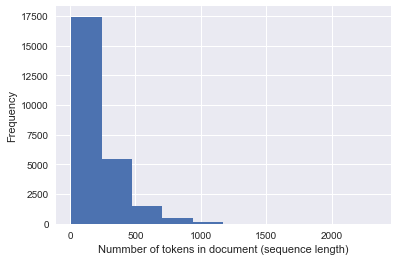

In [161]:
seq_lens = pd.Series([len(x) for x in x_train_sequence])
seq_lens.hist()
plt.xlabel('Nummber of tokens in document (sequence length)')
plt.ylabel('Frequency')
plt.show()

In [63]:
seq_lens.describe()

count    25000.000000
mean       225.362560
std        168.574272
min          9.000000
25%        121.000000
50%        167.000000
75%        274.000000
max       2336.000000
dtype: float64

In [8]:
%%time
x_train_sequence_padded = pad_sequences(x_train_sequence)
x_test_sequence_padded = pad_sequences(x_test_sequence)

CPU times: user 2.8 s, sys: 422 ms, total: 3.22 s
Wall time: 2.22 s


In [66]:
len(x_train_sequence_padded[0])

2336

In [9]:
%%time
maxlen = 250
x_train_sequence_padded = pad_sequences(x_train_sequence, maxlen=maxlen)
x_test_sequence_padded = pad_sequences(x_test_sequence, maxlen)

CPU times: user 1.93 s, sys: 57.2 ms, total: 1.99 s
Wall time: 1.01 s


In [166]:
x_train_sequence_padded.shape

(25000, 250)

In [69]:
x_train_sequence_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,  4820, 16797, 18857,  5627,  7069,
       18914, 28494,

#### learned

In [70]:
x_train_sequence_padded.shape

(25000, 250)

In [13]:
embedding_dim = 300

In [240]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features,
                        embedding_dim,
                        input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
flatten_34 (Flatten)         (None, 75000)             0         
_________________________________________________________________
dense_109 (Dense)            (None, 16)                1200016   
_________________________________________________________________
dropout_73 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_74 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 17        
Total para

In [419]:
def run_cross_val(create_model,
                  epochs=5, batch_size=128, cv=3, verbose=1):
    # create model
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=verbose)

    results = cross_val_score(model,
                              x_train_sequence_padded, y_train, cv=cv)
    results_mean = results.mean()
    results_std = results.std()
    results_string = 'Results: {}, mean: {:.2f}, std: {:.2f}'
    print(results_string.format(results, results_mean, results_std))

In [176]:
run_cross_val(create_model)

Epoch 1/5
16666/16666 [==============================] - 28s 2ms/step - loss: 0.5520 - acc: 0.7352
Epoch 2/5
16666/16666 [==============================] - 30s 2ms/step - loss: 0.2885 - acc: 0.8784
Epoch 3/5
16666/16666 [==============================] - 29s 2ms/step - loss: 0.1084 - acc: 0.9657
Epoch 4/5
16666/16666 [==============================] - 29s 2ms/step - loss: 0.0427 - acc: 0.9858
Epoch 5/5
8334/8334 [==============================] - 2s 230us/step
Epoch 1/5
16667/16667 [==============================] - 31s 2ms/step - loss: 0.6837 - acc: 0.5373
Epoch 2/5
16667/16667 [==============================] - 30s 2ms/step - loss: 0.4547 - acc: 0.8124
Epoch 3/5
16667/16667 [==============================] - 29s 2ms/step - loss: 0.2172 - acc: 0.9362
Epoch 4/5
16667/16667 [==============================] - 27s 2ms/step - loss: 0.1015 - acc: 0.9761
Epoch 5/5
8333/8333 [==============================] - 2s 224us/step
Epoch 1/5
16667/16667 [==============================] - 29s 2ms/step 

#### explore

In [177]:
model = create_model()
model.fit(x_train_sequence_padded, y_train, epochs=5)

Epoch 1/5
25000/25000 [==============================] - 138s 6ms/step - loss: 0.5838 - acc: 0.6591
Epoch 2/5
25000/25000 [==============================] - 147s 6ms/step - loss: 0.2878 - acc: 0.8954
Epoch 3/5
25000/25000 [==============================] - 143s 6ms/step - loss: 0.1167 - acc: 0.9627
Epoch 4/5
25000/25000 [==============================] - 151s 6ms/step - loss: 0.0440 - acc: 0.9862
Epoch 5/5
25000/25000 [==============================] - 149s 6ms/step - loss: 0.0312 - acc: 0.9900


In [179]:
model.get_weights()[0].shape

(40000, 300)

In [180]:
weights = model.get_weights()[0]

In [67]:
def most_similar(weights, query_word, n=10):
    # get the word vector for the provided word
    get_weights = lambda w: weights[vec.vocabulary_[w]]
    # calculates the Euclidean distance between two vectors
    euclidean_dist = lambda x, y: np.linalg.norm(x - y)
    # get the query word weights
    query_word_weights = get_weights(query_word)
    # calculate distance between all words in the vocabulary
    # and the query word
    distances = ((euclidean_dist(query_word_weights,
                                 get_weights(word)), word)
                 for word in vec.vocabulary_)
    # sort the output by distance in ascending order and
    # take the top n
    closest_n = sorted(distances, key=lambda x: x[0])[:n]
    return closest_n

In [204]:
most_similar(weights, 'waste')

[(0.0, 'waste'),
 (1.6038712, 'worst'),
 (1.7018473, 'terrible'),
 (1.713828, 'mess'),
 (1.7219851, 'pointless'),
 (1.7603508, 'lacks'),
 (1.7982241, 'fails'),
 (1.8001578, 'worse'),
 (1.8053883, 'boring'),
 (1.8066409, 'disappointment')]

In [205]:
most_similar(weights, 'excellent')

[(0.0, 'excellent'),
 (1.3448552, 'amazing'),
 (1.4411327, 'excellently'),
 (1.4792386, 'flawless'),
 (1.490075, 'edie'),
 (1.4923619, 'ramones'),
 (1.4968675, 'mcintire'),
 (1.4999555, 'delightfully'),
 (1.5005722, 'victoria'),
 (1.5198689, 'friendship')]

In [206]:
most_similar(weights, 'movie')

[(0.0, 'movie'),
 (0.8663221, '00'),
 (0.9154326, 'victimize'),
 (0.9188335, 'aubuchon'),
 (0.9227289, 'meting'),
 (0.9274821, 'arvanitis'),
 (0.9300187, 'unbalance'),
 (0.93212825, 'ithaca'),
 (0.934246, 'svea'),
 (0.9349057, 'clonkers')]

#### pre-trained

In [206]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!rm glove.6B.zip
!rm glove.6B.50d.txt
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt

--2018-05-20 12:39:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu... 171.64.67.140
Connecting to nlp.stanford.edu|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-05-20 12:39:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  9.29MB/s    in 78s     

2018-05-20 12:40:52 (10.5 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [210]:
!ls -lht glove*

-rw-rw-r--@ 1 amir.ziai  10000   990M Aug 27  2014 glove.6B.300d.txt


In [246]:
!head -1 glove.6B.300d.txt

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

In [222]:
len(embedding)

400000

In [274]:
len(vec.vocabulary_)

44490

In [277]:
def load_embedding(path, vec, embedding_dim):
    embedding = {}
    for line in open(path):
        word, *values = line.split()
        embedding[word] = np.asarray(values)
    
    embedding_matrix = np.random.randn(len(vec.vocabulary_),
                                       embedding_dim)
    no_tokens = len(vec.vocabulary_)
    found = 0
    for word_index, word in enumerate(vec.get_feature_names()):
        if word in embedding:
            found += 1
            embedding_matrix[word_index] = embedding[word]
            
    report_string = 'Found {}/{} ({:.2f}%) of tokens in the embedding'
    pct = 100 * found / no_tokens
    print(report_string.format(found, no_tokens, pct))
        
    return embedding_matrix

In [84]:
%%time
embedding_glove300d = load_embedding('glove.6B.300d.txt', vec, 300)

Found 38592/40000 (96.48%) of tokens in the embedding
CPU times: user 26.1 s, sys: 3.58 s, total: 29.7 s
Wall time: 30 s


In [85]:
embedding_glove300d.shape

(40000, 300)

In [86]:
most_similar(embedding_glove300d, 'waste')

[(0.0, 'waste'),
 (4.9500698594374155, 'wastes'),
 (5.392397398609603, 'disposal'),
 (5.430392490554037, 'recycling'),
 (5.532842868201304, 'garbage'),
 (5.690792676079204, 'dump'),
 (5.942087728603073, 'trash'),
 (6.026556199784952, 'sewage'),
 (6.159765951790217, 'landfill'),
 (6.168820450252348, 'toxic')]

In [87]:
most_similar(embedding_glove300d, 'excellent')

[(0.0, 'excellent'),
 (4.349355808502943, 'good'),
 (4.521333257588436, 'terrific'),
 (4.528437564408916, 'superb'),
 (5.098407751439649, 'well'),
 (5.152522611049086, 'wonderful'),
 (5.322126313489306, 'quality'),
 (5.399403327170717, 'best'),
 (5.408668153309694, 'impressive'),
 (5.4223888071187165, 'exceptional')]

In [88]:
most_similar(embedding_glove300d, 'movie')

[(0.0, 'movie'),
 (3.632431241088511, 'movies'),
 (3.6684420774405804, 'film'),
 (4.39624693123189, 'films'),
 (5.262785903275571, 'sequel'),
 (5.266326368283497, 'hollywood'),
 (5.442663627031183, 'remake'),
 (5.522284491843334, 'starring'),
 (5.661980645848911, 'starred'),
 (5.696968597382557, 'comedy')]

In [122]:
most_similar(word2vec_300d, 'waste')

[(0.0, 'waste'),
 (17.320508075688775, 'importance'),
 (17.320508075688775, 'suspected'),
 (34.64101615137755, 'initially'),
 (34.64101615137755, 'margin'),
 (51.96152422706632, 'watched'),
 (51.96152422706632, 'rare'),
 (69.2820323027551, 'weak'),
 (69.2820323027551, 'meters'),
 (86.60254037844386, 'yourself')]

In [124]:
most_similar(word2vec_300d, 'movie')

[(0.0, 'movie'),
 (17.320508075688775, 'adding'),
 (17.320508075688775, 'beginning'),
 (34.64101615137755, 'successful'),
 (34.64101615137755, 'forced'),
 (51.96152422706632, 'toward'),
 (69.2820323027551, 'ensure'),
 (69.2820323027551, 'travel'),
 (86.60254037844386, 'passed'),
 (103.92304845413264, 'looked')]

#### feed-forward network with pre-trained GloVe

In [172]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # set the weights
    model.layers[0].set_weights([embedding_glove300d])
    model.layers[0].trainable = False
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

create_model().summary()
run_cross_val(create_model, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_81 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
flatten_76 (Flatten)         (None, 75000)             0         
_________________________________________________________________
dense_204 (Dense)            (None, 16)                1200016   
_________________________________________________________________
dropout_129 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_130 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 17        
Total para

In [200]:
model = create_model()
history = model.fit(x_train_sequence_padded,
                    y_train,
                    epochs=5,
                    validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 22s 956us/step - loss: 0.7304 - acc: 0.5539 - val_loss: 0.8171 - val_acc: 0.0000e+00
Epoch 2/5
22500/22500 [==============================] - 19s 844us/step - loss: 0.6874 - acc: 0.5558 - val_loss: 0.8071 - val_acc: 0.0000e+00
Epoch 3/5
22500/22500 [==============================] - 19s 851us/step - loss: 0.6877 - acc: 0.5556 - val_loss: 0.8043 - val_acc: 0.0000e+00
Epoch 4/5
22500/22500 [==============================] - 20s 873us/step - loss: 0.6900 - acc: 0.5558 - val_loss: 0.7946 - val_acc: 0.0000e+00
Epoch 5/5
22500/22500 [==============================] - 19s 827us/step - loss: 0.6890 - acc: 0.5554 - val_loss: 0.8123 - val_acc: 0.0000e+00


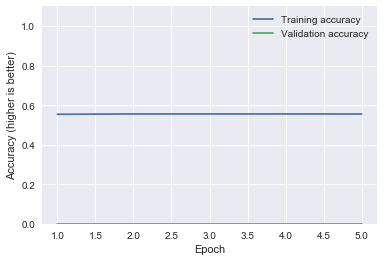

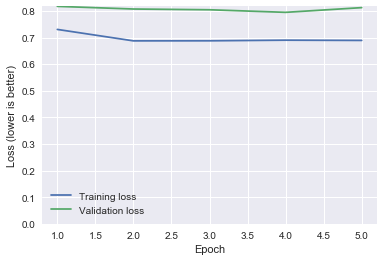

In [202]:
plot_history(history)

In [221]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # set the weights
    model.layers[0].set_weights([embedding_glove300d])
    model.layers[0].trainable = False
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

create_model().summary()
run_cross_val(create_model, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_117 (Embedding)    (None, 250, 300)          12000000  
_________________________________________________________________
flatten_102 (Flatten)        (None, 75000)             0         
_________________________________________________________________
dense_275 (Dense)            (None, 16)                1200016   
_________________________________________________________________
dense_276 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_277 (Dense)            (None, 1)                 17        
Total params: 13,200,305
Trainable params: 1,200,305
Non-trainable params: 12,000,000
_________________________________________________________________
Epoch 1/5
16666/16666 [==============================] - 9s 548us/step - loss: 0.7940 - acc: 0.7200
Epoch 2/5
16666/16666 

# conv1d (move)

In [211]:
def create_model():
    embedding_layer = Embedding(max_features,
                            embedding_dim,
                            weights=[embedding_glove300d],
                            input_length=maxlen,
                            trainable=False)

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(maxlen,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(16, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(16, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    # x = MaxPooling1D(5)(x)
#     x = Conv1D(16, 5, activation='relu')(x)
#     x = GlobalMaxPooling1D()(x)
    x = Dense(16, activation='relu')(x)
    # preds = Dense(len(labels_index), activation='softmax')(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    
#     model = Sequential()
#     model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
#     model.add(Flatten())
    
#     model.add(Conv1D(16, 5, activation='relu'))
#     model.add(MaxPooling1D(5))
    
# #     model.add(Dense(16, activation='relu'))
# #     model.add(Dropout(0.5))
# #     model.add(Dense(16, activation='relu'))
# #     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))
    
#     # set the weights
#     model.layers[0].set_weights([embedding_glove300d])
#     model.layers[0].trainable = False
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

create_model().summary()
# run_cross_val(create_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 250)               0         
_________________________________________________________________
embedding_95 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 246, 16)           24016     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 49, 16)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 45, 16)            1296      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 16)                0         
_________________________________________________________________
dense_241 (Dense)            (None, 16)                272       
__________

In [212]:
model = create_model()
model.fit(x_train_sequence_padded, y_train, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 37s 2ms/step - loss: 0.4893 - acc: 0.7541 - val_loss: 0.3115 - val_acc: 0.8640
Epoch 2/5
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3525 - acc: 0.8467 - val_loss: 0.7245 - val_acc: 0.6408
Epoch 3/5
22500/22500 [==============================] - 36s 2ms/step - loss: 0.3080 - acc: 0.8699 - val_loss: 0.4673 - val_acc: 0.7872
Epoch 4/5
22500/22500 [==============================] - 37s 2ms/step - loss: 0.2715 - acc: 0.8868 - val_loss: 0.6264 - val_acc: 0.7172
Epoch 5/5
 5472/22500 [======>.......................] - ETA: 27s - loss: 0.2235 - acc: 0.9068

KeyboardInterrupt: 

### Recurrent Neural Networks

#### Order matters

In [262]:
sentences_order_matters = [
    'movie is good and not a waste',
    'movie is a waste and not good',
    'movie is not a waste and good',
    'movie is not good and a waste'
]
sentiments = [1, 0, 1, 0]

In [ ]:
vec_order_matters = CountVectorizer()
# build the vocabulary
vec_order_matters.fit(sentences_order_matters);  

In [385]:
vec_order_matters.vocabulary_

{'movie': 3, 'is': 2, 'good': 1, 'and': 0, 'not': 4, 'waste': 5}

In [386]:
sequence_order_matters = sequence_builder(vec_order_matters,
                                          sentences_order_matters)
sequence_order_matters

array([[3, 2, 1, 0, 4, 5],
       [3, 2, 5, 0, 4, 1],
       [3, 2, 4, 5, 0, 1],
       [3, 2, 4, 1, 0, 5]])

In [387]:
sequence_order_matters.shape

(4, 6)

In [418]:
model = Sequential()
model.add(Embedding(len(vec_order_matters.vocabulary_),
                    embedding_dim,
                    input_length=len(sequence_order_matters[0])))
model.add(SimpleRNN(5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
model.fit(sequence_order_matters, np.array(sentiments), epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_150 (Embedding)    (None, 6, 300)            1800      
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 5)                 1530      
_________________________________________________________________
dense_324 (Dense)            (None, 1)                 6         
Total params: 3,336
Trainable params: 3,336
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 4s 881ms/step - loss: 0.6970 - acc: 0.5000
Epoch 2/20
4/4 [==============================] - 0s 2ms/step - loss: 0.6839 - acc: 0.5000
Epoch 3/20
4/4 [==============================] - 0s 2ms/step - loss: 0.6709 - acc: 0.7500
Epoch 4/20
4/4 [==============================] - 0s 1ms/step - loss: 0.6589 - acc: 0.7500
Epoch 5/20
4/4 [======================

#### Why bag-of-words doesn't work

In [416]:
x = pd.DataFrame({token: [1] * len(sentences_order_matters)
                  for token in vec_order_matters.vocabulary_})
x

,movie,is,good,and,not,waste
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1


In [417]:
rf = RandomForestClassifier()
rf.fit(x, sentiments)
print('Accuracy: {:.2f}%'.format(100 * rf.score(u, sentiments)))

Accuracy: 50.00%


#### Sample unseen review

In [394]:
new_review = 'a waste and is not a good movie'
new_review_seq = [vec_order_matters.vocabulary_[token]
                  for token in new_review.split()
                  if token in vec_order_matters.vocabulary_
                 ]
model.predict(np.array([new_review_seq]))

array([[0.37097317]], dtype=float32)

#### SimpleRNN for IMDB

In [422]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

run_cross_val(create_model)

Epoch 1/5
16666/16666 [==============================] - 65s 4ms/step - loss: 0.5624 - acc: 0.7437
Epoch 2/5
16666/16666 [==============================] - 61s 4ms/step - loss: 0.3706 - acc: 0.8463
Epoch 3/5
16666/16666 [==============================] - 61s 4ms/step - loss: 0.2015 - acc: 0.9272
Epoch 4/5
16666/16666 [==============================] - 62s 4ms/step - loss: 0.0961 - acc: 0.9710
Epoch 5/5
8334/8334 [==============================] - 10s 1ms/step
Epoch 1/5
16667/16667 [==============================] - 67s 4ms/step - loss: 0.5376 - acc: 0.7335
Epoch 2/5
16667/16667 [==============================] - 63s 4ms/step - loss: 0.3300 - acc: 0.8781
Epoch 3/5
16667/16667 [==============================] - 60s 4ms/step - loss: 0.2223 - acc: 0.9234
Epoch 4/5
16667/16667 [==============================] - 60s 4ms/step - loss: 0.1474 - acc: 0.9510
Epoch 5/5
8333/8333 [==============================] - 10s 1ms/step
Epoch 1/5
16667/16667 [==============================] - 66s 4ms/step - 

In [429]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

create_model().summary()
run_cross_val(create_model)

Epoch 1/5
16666/16666 [==============================] - 102s 6ms/step - loss: 0.5023 - acc: 0.7679
Epoch 2/5
16666/16666 [==============================] - 93s 6ms/step - loss: 0.2841 - acc: 0.8925
Epoch 3/5
16666/16666 [==============================] - 91s 5ms/step - loss: 0.1766 - acc: 0.9392
Epoch 4/5
16666/16666 [==============================] - 92s 6ms/step - loss: 0.1018 - acc: 0.9698
Epoch 5/5
8334/8334 [==============================] - 13s 2ms/step
Epoch 1/5
16667/16667 [==============================] - 98s 6ms/step - loss: 0.5139 - acc: 0.7428
Epoch 2/5
16667/16667 [==============================] - 90s 5ms/step - loss: 0.2645 - acc: 0.9027
Epoch 3/5
16667/16667 [==============================] - 92s 6ms/step - loss: 0.1497 - acc: 0.9506
Epoch 4/5
16667/16667 [==============================] - 90s 5ms/step - loss: 0.0784 - acc: 0.9775
Epoch 5/5
8333/8333 [==============================] - 13s 2ms/step
Epoch 1/5
16667/16667 [==============================] - 97s 6ms/step -

#### Stacked bi-directional LSTMS

In [426]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

create_model().summary()
run_cross_val(create_model, epochs=5)

Epoch 1/5
16666/16666 [==============================] - 155s 9ms/step - loss: 0.4729 - acc: 0.7952
Epoch 2/5
16666/16666 [==============================] - 147s 9ms/step - loss: 0.2274 - acc: 0.9164
Epoch 3/5
16666/16666 [==============================] - 148s 9ms/step - loss: 0.1206 - acc: 0.9622
Epoch 4/5
16666/16666 [==============================] - 153s 9ms/step - loss: 0.0699 - acc: 0.9802
Epoch 5/5
8334/8334 [==============================] - 22s 3ms/step
Epoch 1/5
16667/16667 [==============================] - 162s 10ms/step - loss: 0.5017 - acc: 0.7401
Epoch 2/5
16667/16667 [==============================] - 161s 10ms/step - loss: 0.2434 - acc: 0.9135
Epoch 3/5
16667/16667 [==============================] - 168s 10ms/step - loss: 0.1202 - acc: 0.9618
Epoch 4/5
16667/16667 [==============================] - 163s 10ms/step - loss: 0.0734 - acc: 0.9794
Epoch 5/5
8333/8333 [==============================] - 23s 3ms/step
Epoch 1/5
16667/16667 [==============================] - 173

#### Stacked 1ConvNet

In [306]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

create_model().summary()
cv_report(create_model)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_164 (Dropout)        (None, 250, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 244, 32)           67232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 42, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dro

#### ConvNet + RNN

In [423]:
x_train_sequence_padded.shape

(25000, 250)

In [308]:
# stacked LSTMs
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    # Add 1D conv + max pooling
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(GRU(64, recurrent_dropout=0.5))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cv_report(create_model, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_73 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_172 (Dropout)        (None, 250, 300)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 244, 32)           67232     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 42, 32)            7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)                0         
__________

## seq2seq

### Machine Translation

#### char-level

Visit http://www.manythings.org/anki/ for more information

In [309]:
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!rm spa-eng.zip

--2018-05-21 16:54:55--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org... 104.24.109.196, 104.24.108.196, 2400:cb00:2048:1::6818:6dc4, ...
Connecting to www.manythings.org|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2786685 (2.7M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.66M  2.22MB/s    in 1.2s    

2018-05-21 16:54:57 (2.22 MB/s) - ‘spa-eng.zip’ saved [2786685/2786685]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [310]:
!ls -lht spa.txt

-rw-r--r--@ 1 amir.ziai  10000   7.7M May 13 15:50 spa.txt


In [330]:
!wc -l spa.txt

  118964 spa.txt


In [17]:
%%time
sources = []
targets = []
chars_source = set()
chars_target = set()
max_source = 0
max_target = 0
path = 'spa.txt'

for line in open(path):
     source, target = line.strip().split('\t')
        
     sources.append(source)
     targets.append(target)
     
     max_source = max(max_source, len(source))
     max_target = max(max_target, len(target))
     for c in source:
        chars_source.add(c)
     for c in target:
        chars_target.add(c)

CPU times: user 1.04 s, sys: 21.9 ms, total: 1.06 s
Wall time: 1.06 s


In [18]:
source_dict = dict(zip(chars_source, range(len(chars_source))))
target_dict = dict(zip(chars_target, range(len(chars_target))))
print('Source characteres: {}'.format(len(source_dict)))
print('Target characteres: {}'.format(len(target_dict)))

Source characteres: 90
Target characteres: 111


In [19]:
%%time
encoder_in = np.zeros((len(sources), max_source, len(chars_source)))
decoder_in = np.zeros((len(sources), max_target, len(chars_target)))
decoder_out = np.zeros((len(sources), max_target, len(chars_target)))

for i, (source, target) in enumerate(zip(sources, targets)):
    for t, c in enumerate(source):
        encoder_in[i, t, source_dict[c]] = 1
        
    for t, c in enumerate(target):
        decoder_in[i, t, target_dict[c]] = 1
        if t > 0:
            decoder_out[i, t - 1, target_dict[c]] = 1

CPU times: user 8.82 s, sys: 4.24 s, total: 13.1 s
Wall time: 13.3 s


In [43]:
num_encoder_tokens = len(chars_source)
num_decoder_tokens = len(chars_target)
encoder_input_data = encoder_in
decoder_input_data = decoder_in
decoder_target_data = decoder_out
batch_size = 64
epochs = 100

In [59]:
data_path = 'spa.txt'
num_samples = 10000

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 86
Max sequence length for inputs: 17
Max sequence length for outputs: 42


In [54]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 21s 3ms/step - loss: 1.1372 - val_loss: 1.2104
Epoch 2/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.9464 - val_loss: 1.0098
Epoch 3/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.8217 - val_loss: 0.9363
Epoch 4/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.7602 - val_loss: 0.8850
Epoch 5/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.7104 - val_loss: 0.8296
Epoch 6/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.6713 - val_loss: 0.7948
Epoch 7/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.6385 - val_loss: 0.7816
Epoch 8/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.6101 - val_loss: 0.7431
Epoch 9/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5842 - val_loss: 0.7287
Epoch 10/100
800

/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_23 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_22/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_22/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [60]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Hi.
Decoded sentence: Hola.

-
Input sentence: Run!
Decoded sentence: ¡Corre!

-
Input sentence: Run.
Decoded sentence: Corred.

-
Input sentence: Who?
Decoded sentence: ¿Quién?

-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Jump!
Decoded sentence: ¡Salta!

-
Input sentence: Jump.
Decoded sentence: Salte.

-
Input sentence: Stop!
Decoded sentence: ¡Pare!

-
Input sentence: Stop!
Decoded sentence: ¡Pare!

-
Input sentence: Stop!
Decoded sentence: ¡Pare!

-
Input sentence: Wait!
Decoded sentence: ¡

In [65]:
encoder_input_data.shape

(10000, 17, 71)

In [68]:
encoder_input_data[-2:-1]

(1, 17, 71)

In [64]:
input_seq.shape

(1, 17, 71)

In [62]:
seq_index = 1202
# Take one sequence (part of the training set)
# for trying out decoding.
input_seq = encoder_input_data[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(input_seq)
print('-')
print('Input sentence:', input_texts[seq_index])
print('Decoded sentence:', decoded_sentence)

-
Input sentence: Is this OK?
Decoded sentence: ¿Esto es bueno?



### Chatbots

In [69]:
# !wget https://raw.githubusercontent.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/master/vocabulary_movie
# !wget https://raw.githubusercontent.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/master/conversation.py

--2018-05-22 16:18:10--  https://raw.githubusercontent.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/master/vocabulary_movie
Resolving raw.githubusercontent.com... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 213637 (209K) [text/plain]
Saving to: ‘vocabulary_movie’

vocabulary_movie    100%[===================>] 208.63K  --.-KB/s    in 0.07s   

2018-05-22 16:18:15 (2.78 MB/s) - ‘vocabulary_movie’ saved [213637/213637]



In [72]:
!wget https://raw.githubusercontent.com/chen0040/keras-chatbot-web-api/master/chatbot_train/data/cornell-dialogs/movie_lines_cleaned_10k.txt

--2018-05-22 18:11:49--  https://raw.githubusercontent.com/chen0040/keras-chatbot-web-api/master/chatbot_train/data/cornell-dialogs/movie_lines_cleaned_10k.txt
Resolving raw.githubusercontent.com... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542439 (530K) [text/plain]
Saving to: ‘movie_lines_cleaned_10k.txt’

movie_lines_cleaned 100%[===================>] 529.73K   639KB/s    in 0.8s    

2018-05-22 18:11:51 (639 KB/s) - ‘movie_lines_cleaned_10k.txt’ saved [542439/542439]



In [80]:
BATCH_SIZE = 64
NUM_EPOCHS = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 800
DATA_PATH = 'movie_lines_cleaned_10k.txt'
WEIGHT_FILE_PATH = 'word-weights.h5'

input_counter = Counter()
target_counter = Counter()

lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []

prev_words = []
for line in lines:

    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]

    if len(prev_words) > 0:
        input_texts.append(prev_words)
        for w in prev_words:
            input_counter[w] += 1

        target_words = next_words[:]
        target_words.insert(0, 'START')
        target_words.append('END')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)

    prev_words = next_words

input_word2idx = dict()
target_word2idx = dict()
for idx, word in enumerate(input_counter.most_common(MAX_VOCAB_SIZE)):
    input_word2idx[word[0]] = idx + 2
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1

input_word2idx['PAD'] = 0
input_word2idx['UNK'] = 1
target_word2idx['UNK'] = 0

input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_encoder_tokens = len(input_idx2word)
num_decoder_tokens = len(target_idx2word)

np.save('word-input-word2idx.npy', input_word2idx)
np.save('word-input-idx2word.npy', input_idx2word)
np.save('word-target-word2idx.npy', target_word2idx)
np.save('word-target-idx2word.npy', target_idx2word)

encoder_input_data = []

encoder_max_seq_length = 0
decoder_max_seq_length = 0

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        w2idx = 1  # default [UNK]
        if w in input_word2idx:
            w2idx = input_word2idx[w]
        encoder_input_wids.append(w2idx)

    encoder_input_data.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_encoder_tokens'] = num_encoder_tokens
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
# np.save('word-context.npy', context)


def generate_batch(input_data, output_text_data):
    num_batches = len(input_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = pad_sequences(input_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = 0  # default [UNK]
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    decoder_input_data_batch[lineIdx, idx, w2idx] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch


encoder_inputs = Input(shape=(None,), name='encoder_inputs')
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=HIDDEN_UNITS,
                              input_length=encoder_max_seq_length, name='encoder_embedding')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [encoder_state_h, encoder_state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

json = model.to_json()
open('word-architecture.json', 'w').write(json)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(encoder_input_data, target_texts, test_size=0.2, random_state=42)

print(len(Xtrain))
print(len(Xtest))

train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)

train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)
model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,
                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])

model.save_weights(WEIGHT_FILE_PATH)

{'num_encoder_tokens': 802, 'num_decoder_tokens': 801, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


7997
2000
Epoch 1/100
124/124 [==============================] - 92s 742ms/step - loss: 1.5122 - val_loss: 1.4305
Epoch 2/100
124/124 [==============================] - 83s 667ms/step - loss: 1.4234 - val_loss: 1.3461
Epoch 3/100
124/124 [==============================] - 86s 696ms/step - loss: 1.3404 - val_loss: 1.2763
Epoch 4/100
124/124 [==============================] - 83s 667ms/step - loss: 1.2765 - val_loss: 1.2317
Epoch 5/100
124/124 [==============================] - 88s 711ms/step - loss: 1.2319 - val_loss: 1.1981
Epoch 6/100
124/124 [==============================] - 84s 679ms/step - loss: 1.1991 - val_loss: 1.1759
Epoch 7/100
124/124 [==============================] - 86s 693ms/step - loss: 1.1806 - val_loss: 1.1622
Epoch 8/100
124/124 [==============================] - 86s 695ms/step - loss: 1.1562 - val_loss: 1.1483
Epoch 9/100
124/124 [==============================] - 83s 672ms/step - loss: 1.1368 - val_loss: 1.1374
Epoch 10/100
124/124 [==============================] 

124/124 [==============================] - 76s 615ms/step - loss: 0.3080 - val_loss: 1.7739
Epoch 80/100
124/124 [==============================] - 75s 605ms/step - loss: 0.3023 - val_loss: 1.7794
Epoch 81/100
124/124 [==============================] - 76s 616ms/step - loss: 0.2961 - val_loss: 1.7926
Epoch 82/100
124/124 [==============================] - 78s 633ms/step - loss: 0.2893 - val_loss: 1.8038
Epoch 83/100
124/124 [==============================] - 79s 634ms/step - loss: 0.2833 - val_loss: 1.8207
Epoch 84/100
124/124 [==============================] - 77s 618ms/step - loss: 0.2749 - val_loss: 1.8287
Epoch 85/100
124/124 [==============================] - 76s 612ms/step - loss: 0.2710 - val_loss: 1.8383
Epoch 86/100
124/124 [==============================] - 78s 626ms/step - loss: 0.2637 - val_loss: 1.8501
Epoch 87/100
124/124 [==============================] - 76s 615ms/step - loss: 0.2578 - val_loss: 1.8609
Epoch 88/100
124/124 [==============================] - 74s 597ms/st

In [81]:
WEIGHT_FILE_PATH

'word-weights.h5'

### inference

In [88]:
HIDDEN_UNITS = 256


class CornellWordChatBot(object):
    model = None
    encoder_model = None
    decoder_model = None
    input_word2idx = None
    input_idx2word = None
    target_word2idx = None
    target_idx2word = None
    max_encoder_seq_length = None
    max_decoder_seq_length = None
    num_encoder_tokens = None
    num_decoder_tokens = None

    def __init__(self):
        self.input_word2idx = np.load('word-input-word2idx.npy').item()
        self.input_idx2word = np.load('word-input-idx2word.npy').item()
        self.target_word2idx = np.load('word-target-word2idx.npy').item()
        self.target_idx2word = np.load('word-target-idx2word.npy').item()
        context = np.load('word-context.npy').item()
        self.max_encoder_seq_length = context['encoder_max_seq_length']
        self.max_decoder_seq_length = context['decoder_max_seq_length']
        self.num_encoder_tokens = context['num_encoder_tokens']
        self.num_decoder_tokens = context['num_decoder_tokens']

        encoder_inputs = Input(shape=(None, ), name='encoder_inputs')
        encoder_embedding = Embedding(input_dim=self.num_encoder_tokens, output_dim=HIDDEN_UNITS,
                                      input_length=self.max_encoder_seq_length, name='encoder_embedding')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name="encoder_lstm")
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, self.num_decoder_tokens), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        # model_json = open('../chatbot_train/models/cornell/word-architecture.json', 'r').read()
        # self.model = model_from_json(model_json)
        self.model.load_weights('word-weights.h5')
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    def reply(self, input_text):
        input_seq = []
        input_wids = []
        for word in nltk.word_tokenize(input_text.lower()):
            idx = 1  # default [UNK]
            if word in self.input_word2idx:
                idx = self.input_word2idx[word]
            input_wids.append(idx)
        input_seq.append(input_wids)
        input_seq = pad_sequences(input_seq, self.max_encoder_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.target_word2idx['START']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'START' and sample_word != 'END':
                target_text += ' ' + sample_word

            if sample_word == 'END' or target_text_len >= self.max_decoder_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, self.num_decoder_tokens))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()

    def test_run(self):
        print(self.reply('do you listen to this crap?'))
        print(self.reply('Did you change your hair?'))
        print(self.reply('Get out!'))

In [89]:
!ls -lht *.npy

-rw-r--r--@ 1 amir.ziai  10000   442B May 23 00:26 word-context.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-input-idx2word.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-input-word2idx.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-target-idx2word.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-target-word2idx.npy


In [91]:
bot = CornellWordChatBot()

In [92]:
bot.test_run()

no ... i can UNK you for me .
you 'd have to get her out ?
UNK !


In [95]:
bot.reply('hello')

"UNK a UNK . i saw it . i was UNK in UNK and i 'm coming in ."

In [97]:
bot.reply('my name is amir')

"you 're UNK against one , jesse . you UNK me ."

In [99]:
bot.reply('Haha')

"i 'm UNK , i got ta do . i 'm sorry ."